## Kaggle 手写数字识别

关于数据处理的参考：https://www.kaggle.com/vijaykris/mnist-classification-using-fast-ai-v2

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
# 指定设备
torch.cuda.set_device(1)

In [4]:
PATH = "data/DigitRecognizer/"
sz=28
arch=resnext101_64
bs=64

In [5]:
!ls {PATH}

sample_submission.csv  test.csv  tmp  train.csv


In [6]:
# 根据label文件， 交叉验证分割训练集和验证集
train_csv = f'{PATH}train.csv'
n = len(list(open(train_csv))) - 1 # header is not counted (-1)

In [7]:
# 样本数目
n

42000

## 研究数据

In [8]:
!ls {PATH}

sample_submission.csv  test.csv  tmp  train.csv


In [9]:
train_df = pd.read_csv(train_csv)

In [10]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 数据预处理和交叉验证分割

In [11]:
# 读取CSV
train=pd.read_csv(f'{PATH}/train.csv')
test=pd.read_csv(f'{PATH}/test.csv')

In [12]:
# 训练图像和标签
images=train.iloc[:,1:]
labels=train.iloc[:,0:1]

In [13]:
print(images.shape)
print(labels.shape)
print(test.shape)

(42000, 784)
(42000, 1)
(28000, 784)


In [14]:
# 一维图像转换为二维
images = np.reshape(images.values,(-1, 28, 28))
labels = labels.values.flatten()
test_images =  np.reshape(test.values,(-1, 28, 28))
print(images.shape)
print(labels.shape)
print(test_images.shape)

(42000, 28, 28)
(42000,)
(28000, 28, 28)


In [15]:
images=np.stack((images,)*3, axis=-1)# .astype('float32')
test_images=np.stack((test_images,)*3, axis=-1) #.astype('float32')

In [16]:
print(images.shape)
print(test_images.shape)

(42000, 28, 28, 3)
(28000, 28, 28, 3)


In [17]:
# 省内存
del train
del test

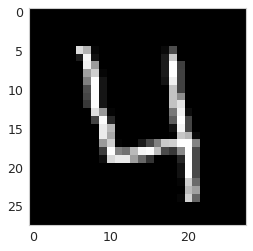

In [18]:
# 查看数据
plt.grid(0)
plt.imshow(images[3])

In [19]:
# 分割数据集
from sklearn.model_selection import train_test_split

train_img, val_img, train_lbl, val_lbl = train_test_split(
    images, labels, test_size=0.2, random_state=3)

In [20]:
print(train_img.shape)
print(val_img.shape)

(33600, 28, 28, 3)
(8400, 28, 28, 3)


## 训练模型

In [21]:
# 数据扩增方式
# transformer
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic + [AddPadding(pad=2)] + [RandomCrop(targ_sz=28)], max_zoom=1.1)

In [22]:
# 构建数据加载器
classes = np.unique(train_lbl)

data=ImageClassifierData.from_arrays(path= f'{PATH}tmp',trn=(train_img/255, train_lbl),
                                     val=(val_img/255, val_lbl),
                                     bs = bs,
                                     classes=classes,
                                     test=test_images/255,
                                     tfms=tfms)

In [23]:
# 构建学习器
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 438/438 [00:26<00:00, 16.57it/s]


 83%|████████▎ | 434/525 [00:08<00:02, 41.68it/s, loss=1.63] 


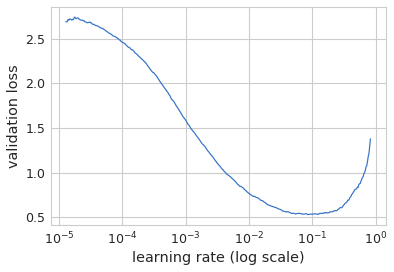

In [24]:
# 找最优学习率
lrf=learn.lr_find()
learn.sched.plot()

In [25]:
# 根据曲线，选择学习率 lr= 0.1
# 进行训练，并根据train loss和 validation loss判断是否过拟合
learn.fit(1e-1, 8)

epoch      trn_loss   val_loss   accuracy                    
    0      0.274983   0.199311   0.93369   
    1      0.198208   0.15306    0.948333                    
    2      0.213818   0.136481   0.955595                    
    3      0.160592   0.13811    0.955357                    
    4      0.152863   0.12799    0.959643                    
    5      0.139646   0.129716   0.961429                    
    6      0.142631   0.119458   0.962143                    
    7      0.137618   0.120047   0.964405                    



[array([0.12005]), 0.9644047619047619]

In [26]:
# 先保存模型
# 当然目前还是欠拟合的
learn.save('first_try')
learn.load('first_try')

## 模型优化

In [27]:
# DropOut手段
# ps是Dropout参数
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

 83%|████████▎ | 437/525 [00:08<00:02, 38.06it/s, loss=2.06] 


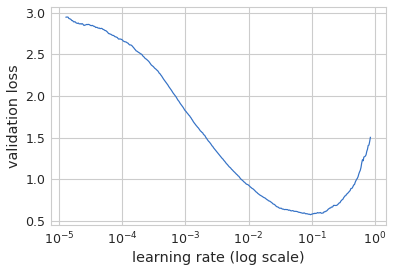

In [28]:
# 找最优学习率
lrf=learn.lr_find()
learn.sched.plot()

In [29]:
# 根据曲线，选择学习率 lr= 0.1
# 进行训练，并根据train loss和 validation loss判断是否过拟合
learn.fit(1e-1, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.317158   0.19464    0.935119  
    1      0.2598     0.1734     0.944881                    
    2      0.207689   0.150801   0.952143                    
    3      0.213899   0.13703    0.954881                    
    4      0.174896   0.130922   0.957381                    



[array([0.13092]), 0.9573809523809523]

In [30]:
learn.save('dropOut')
learn.load('dropOut')

In [31]:
learn.precompute = False

 84%|████████▍ | 442/525 [00:30<00:08,  9.32it/s, loss=1.13] 

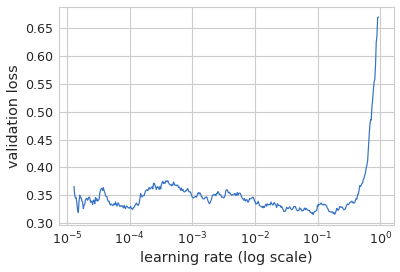

In [32]:
# 找最优学习率
lrf=learn.lr_find()
learn.sched.plot()

In [33]:
# 可以加上SGDR算法
learn.fit(1e-1, n_cycle=4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.26754    0.137729   0.955714  
    1      0.228966   0.143739   0.954405                    
    2      0.222551   0.129113   0.958452                    
    3      0.234704   0.138637   0.955238                    
    4      0.233933   0.128033   0.958214                    
    5      0.213325   0.119944   0.960595                    
    6      0.204307   0.122251   0.960119                    
    7      0.234767   0.132185   0.957024                    
    8      0.234062   0.13402    0.956786                    
    9      0.22086    0.117657   0.961667                    
    10     0.203032   0.123946   0.961071                    
    11     0.183642   0.117649   0.961071                    
    12     0.187012   0.113057   0.963095                    
    13     0.170765   0.110144   0.964048                    
    14     0.179473   0.110842   0.964048                    


[array([0.11084]), 0.964047619047619]

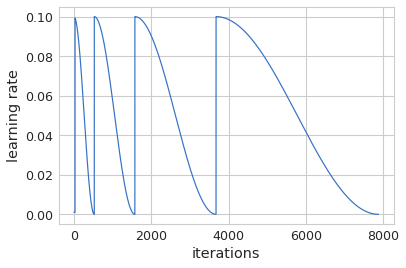

In [34]:
learn.sched.plot_lr()

In [35]:
# 目前还是欠拟合状态
learn.fit(1e-2, n_cycle=3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.183977   0.11308    0.964167  
    1      0.165255   0.11386    0.963214                    
    2      0.174176   0.113564   0.962619                    
    3      0.174515   0.111123   0.964643                    
    4      0.170266   0.110733   0.964405                    
    5      0.177971   0.110655   0.96381                     
    6      0.17023    0.109759   0.964048                    


[array([0.10976]), 0.964047619047619]

## 多分布率处理

In [36]:
# fast.ai 获取指定size的数据集
def get_data(sz):
    # 此处sz是做dataloader时将图像预处理为指定sz大小
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic + [AddPadding(pad=2)] + [RandomCrop(targ_sz=sz)], max_zoom=1.1)
    return ImageClassifierData.from_arrays(path= f'{PATH}tmp',trn=(train_img/255, train_lbl),
                                     val=(val_img/255, val_lbl),
                                     bs = bs,
                                     classes=classes,
                                     test=test_images/255,
                                     tfms=tfms)

 83%|████████▎ | 438/525 [00:29<00:03, 23.94it/s, loss=0.578]

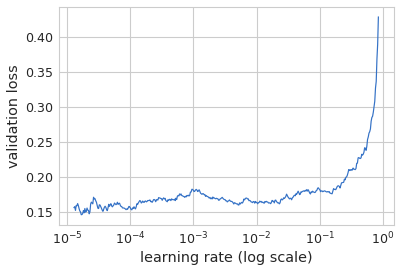

In [37]:
# 找最优学习率
lrf=learn.lr_find()
learn.sched.plot()

In [38]:
# differencial learning rate的分配，除了第三个参数是针对全连接层的，第一二个参数平均分配剩余测网络层
lr = 1e-2
lrs = np.array([lr/9,lr/3,lr])

In [39]:
# 从新训练
# 事实上，可以直接跳过从预训练模型中训练全连接层参数这一步，直接unfreeze进行全部权重的训练
# 但是，预训练模型的卷积层参数不是随机的，而是在ImageNet数据集上训练过的。
#（对于与ImageNet类似的数据，是好事，对于与ImageNet不同的数据集，也比没有要好）
# 但是全连接层又是全部随机的，所以对于全连接层，可以先进行一次训练（在预训练卷积参数的帮助下），使之比随机要好，
# 然后再放开卷积层的参数，对其进行全部的训练
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.105211   0.052219   0.983929  
    1      0.072058   0.038679   0.987143                     
    2      0.04859    0.031206   0.990714                     
    3      0.049083   0.034584   0.988929                     
    4      0.040643   0.028713   0.990476                     
    5      0.029351   0.02445    0.991786                     
    6      0.026229   0.023161   0.991905                     


[array([0.02316]), 0.991904761904762]

In [40]:
learn.save(f'{sz}')

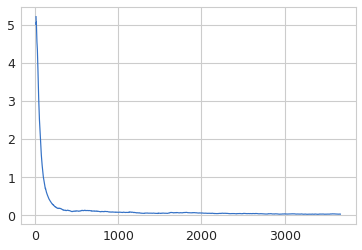

In [41]:
learn.sched.plot_loss()

In [42]:
sz=56

In [43]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.757907   0.570661   0.844286  
    1      0.499019   0.304121   0.914405                    
    2      0.455893   0.281939   0.918571                    
    3      0.402226   0.225838   0.934643                    
    4      0.36548    0.193338   0.942381                    
    5      0.325702   0.182049   0.947024                    
    6      0.318741   0.175933   0.948452                    


[array([0.17593]), 0.9484523809523809]

epoch      trn_loss   val_loss   accuracy                     
    0      0.058693   0.034893   0.989524  
    1      0.054986   0.026994   0.992143                     
    2      0.036006   0.021957   0.992619                     
    3      0.034336   0.025406   0.99131                      
    4      0.026008   0.021791   0.991905                     
    5      0.014845   0.020832   0.993452                     
    6      0.013636   0.01937    0.99381                      


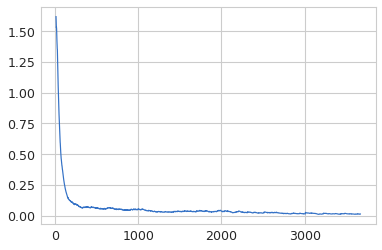

In [44]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')
learn.sched.plot_loss()

In [50]:
learn.load('56')

In [52]:
# sz为56时已经很完美了，trainloss越等于validationloss了。
sz=112

In [47]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      1.185216   0.996413   0.669762  
    1      0.96527    0.736496   0.766905                    
    2      0.868851   0.669329   0.790714                    
    3      0.813786   0.56094    0.823571                    
    4      0.743812   0.505451   0.842619                    
    5      0.714868   0.486642   0.846905                    
    6      0.705779   0.492632   0.8425                      


[array([0.49263]), 0.8425]

epoch      trn_loss   val_loss   accuracy                     
    0      0.056944   0.039509   0.98869   
    1      0.042435   0.028595   0.99119                      
    2      0.024617   0.023517   0.992262                     
    3      0.033676   0.022817   0.992976                     
    4      0.022803   0.022622   0.993571                     
    5      0.013123   0.019921   0.994524                     
    6      0.012305   0.01797    0.994881                      


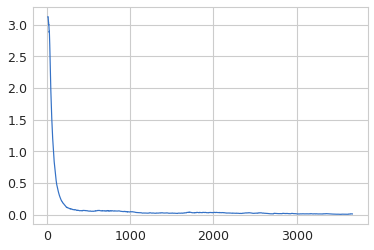

In [48]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')
learn.sched.plot_loss()

## 提交后微调

In [54]:
learn.load('112')

In [68]:
sz=28

In [69]:
learn.set_data(get_data(sz))
learn.freeze()

 86%|████████▋ | 453/525 [00:31<00:06, 10.91it/s, loss=0.832]

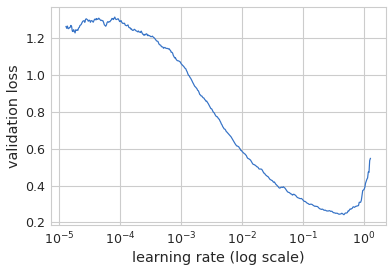

In [70]:
# 找最优学习率
lrf=learn.lr_find()
learn.sched.plot()

In [71]:
# differencial learning rate的分配，除了第三个参数是针对全连接层的，第一二个参数平均分配剩余测网络层
lr = 1e-1
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.14694    0.080192   0.974643  
    1      0.111392   0.06995    0.9775                      
    2      0.106289   0.060855   0.980595                     
    3      0.101301   0.068429   0.978333                     
    4      0.103459   0.053477   0.981786                     
    5      0.082989   0.052716   0.982857                     
    6      0.083448   0.051086   0.982619                     


[array([0.05109]), 0.9826190476190476]

 85%|████████▌ | 448/525 [00:31<00:10,  7.29it/s, loss=0.265] 

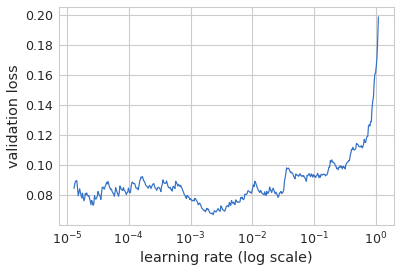

In [72]:
# 找最优学习率
lrf=learn.lr_find()
learn.sched.plot()

In [73]:
learn.unfreeze()

 73%|███████▎  | 384/525 [01:11<00:22,  6.22it/s, loss=0.435]

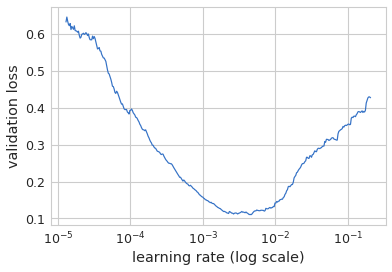

In [74]:
lrf=learn.lr_find()
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                     
    0      0.058292   0.027155   0.991786  
    1      0.042599   0.024554   0.992738                     
    2      0.04625    0.023759   0.992738                     
    3      0.050641   0.023497   0.993333                     
    4      0.030357   0.022129   0.992976                     
    5      0.036625   0.021471   0.994048                     
    6      0.034601   0.021643   0.994048                     


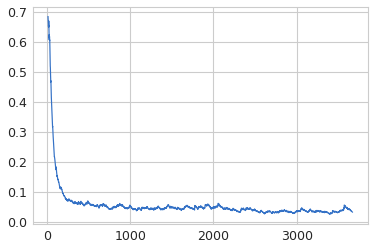

In [75]:
lr = 1e-3
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}Again')
learn.sched.plot_loss()

 51%|█████▏    | 270/525 [00:50<00:40,  6.22it/s, loss=0.095] 

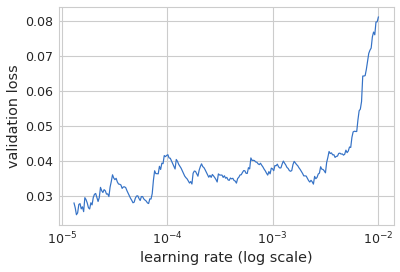

In [76]:
# 还有继续拟合空间
lrf=learn.lr_find()
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                     
    0      0.030013   0.021631   0.993452  
    1      0.038439   0.021415   0.993571                     
    2      0.036066   0.021714   0.993214                     
    3      0.028524   0.020903   0.99381                      
    4      0.026395   0.022412   0.993571                     
    5      0.027481   0.021069   0.994524                     
    6      0.032142   0.02132    0.993929                     


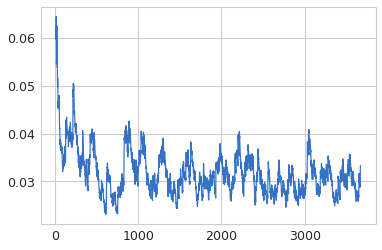

In [77]:
lr = 1e-4
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}Again2')
learn.sched.plot_loss()

loss降不下去了。

In [79]:
sz=112
learn.set_data(get_data(sz))
learn.freeze()

 84%|████████▍ | 441/525 [00:56<00:14,  5.81it/s, loss=4.92]

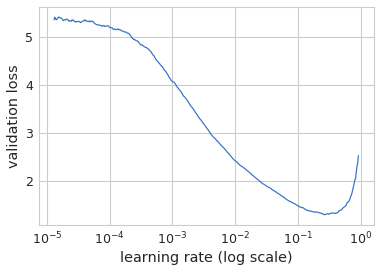

In [80]:
lrf=learn.lr_find()
learn.sched.plot()

In [81]:
lr = 1e-2
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      1.091641   0.756396   0.803214  
    1      0.767363   0.420683   0.885                       
    2      0.691721   0.382925   0.892976                    
    3      0.631434   0.319758   0.909881                    
    4      0.580153   0.291494   0.918095                    
    5      0.568056   0.271639   0.921786                    
    6      0.554687   0.264963   0.923214                    


[array([0.26496]), 0.9232142857142858]

 73%|███████▎  | 382/525 [02:46<01:00,  2.36it/s, loss=0.252] 

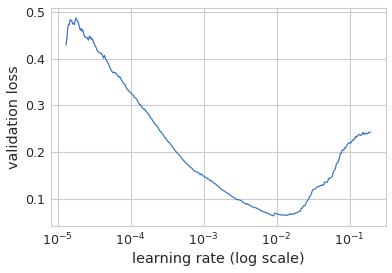

In [82]:
learn.unfreeze()
lrf=learn.lr_find()
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                     
    0      0.022228   0.020633   0.993929  
    1      0.020429   0.01919    0.993929                     
    2      0.014612   0.017838   0.994762                     
    3      0.015562   0.022461   0.993333                      
    4      0.010581   0.022268   0.993929                      
    5      0.00785    0.020098   0.994048                      
    6      0.004554   0.018898   0.99381                       


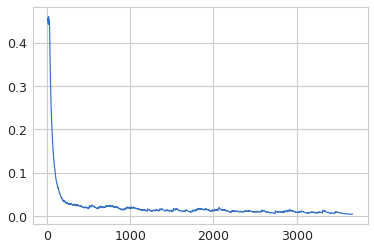

In [83]:
lr = 5e-3
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}Again3')
learn.sched.plot_loss()

## 预测提交

In [84]:
log_preds_test, y_test=learn.TTA(is_test=True)
probs_test=np.mean(np.exp(log_preds_test),0)
probs_test.shape

(28000, 10)

In [85]:
# 转成pandas格式
df = pd.DataFrame(probs_test)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.000017,3.990781e-06,9.998549e-01,6.500037e-05,2.669223e-06,3.329097e-06,4.568560e-06,3.594458e-05,0.000008,0.000005
1,0.999985,3.287467e-07,7.486570e-07,1.814502e-07,1.493309e-07,6.618133e-07,8.587524e-06,2.826225e-07,0.000001,0.000002
2,0.000019,1.306887e-06,1.431316e-04,4.553310e-06,2.107268e-04,6.744819e-06,1.101093e-05,3.909314e-04,0.000048,0.999165
3,0.998095,1.450757e-05,6.196879e-04,3.026148e-05,3.212359e-06,2.989436e-05,8.257570e-04,2.177610e-05,0.000107,0.000252
4,0.000002,1.282164e-06,1.330045e-04,9.995996e-01,5.865684e-08,8.057583e-05,1.854530e-07,3.295734e-06,0.000177,0.000003


In [86]:
# 找概率最大的作为结果
df=df.assign(Label=df.values.argmax(axis=1))
df=df.assign(ImageId=df.index.values+1)

In [87]:
dfResult=df[['ImageId', 'Label']]
dfResult.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [88]:
dfResult.shape

(28000, 2)

In [89]:
# 写入csv文件并压缩
SUBM = f'{PATH}submOverFit/'
os.makedirs(SUBM, exist_ok=True)
dfResult.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [90]:
# 显示文件路径链接
FileLink(f'{SUBM}subm.gz')

/home/ubuntu/Fast.ai_Tips/dl1/data/DigitRecognizer/submOverFit/subm.gz